[[1.30877395e-12 4.17228686e-16]
 [4.17228686e-16 3.77495000e-16]]
Paper Covariance: 
 [[2.44036996e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.44036996e+01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.53302279e+09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.53302279e+09]]
----------------------------------------------------
Identity used in testing: 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


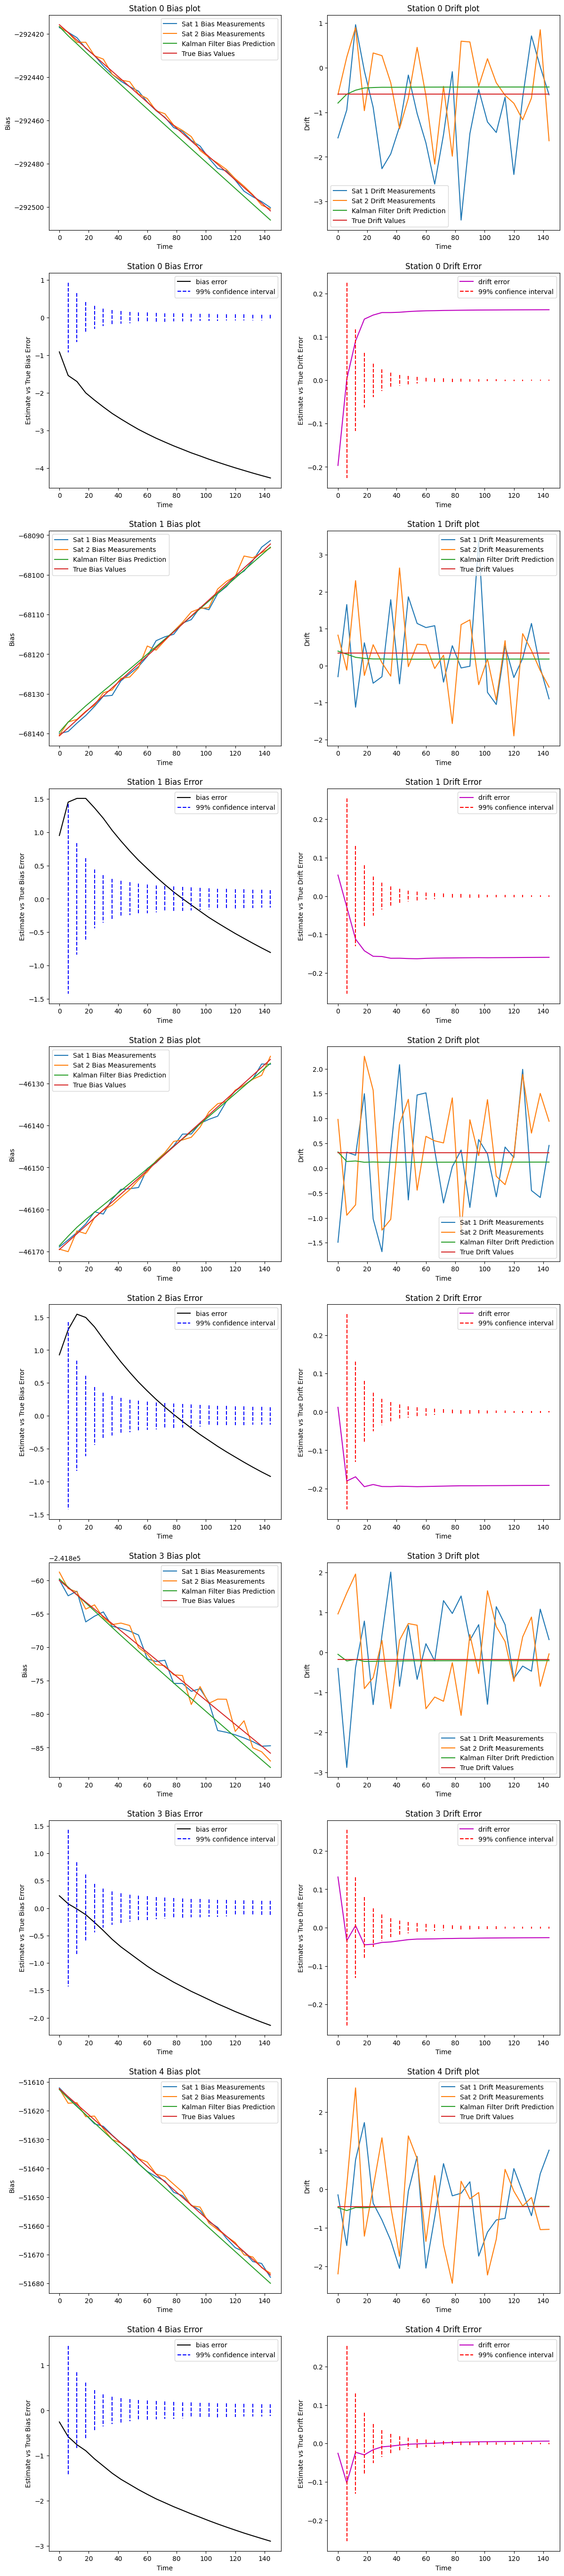

[[2.44036996e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.44036996e+01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.53302279e+09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.53302279e+09]]
[[4.36560000e-21 1.39172509e-24]
 [1.39172509e-24 1.25918778e-24]]


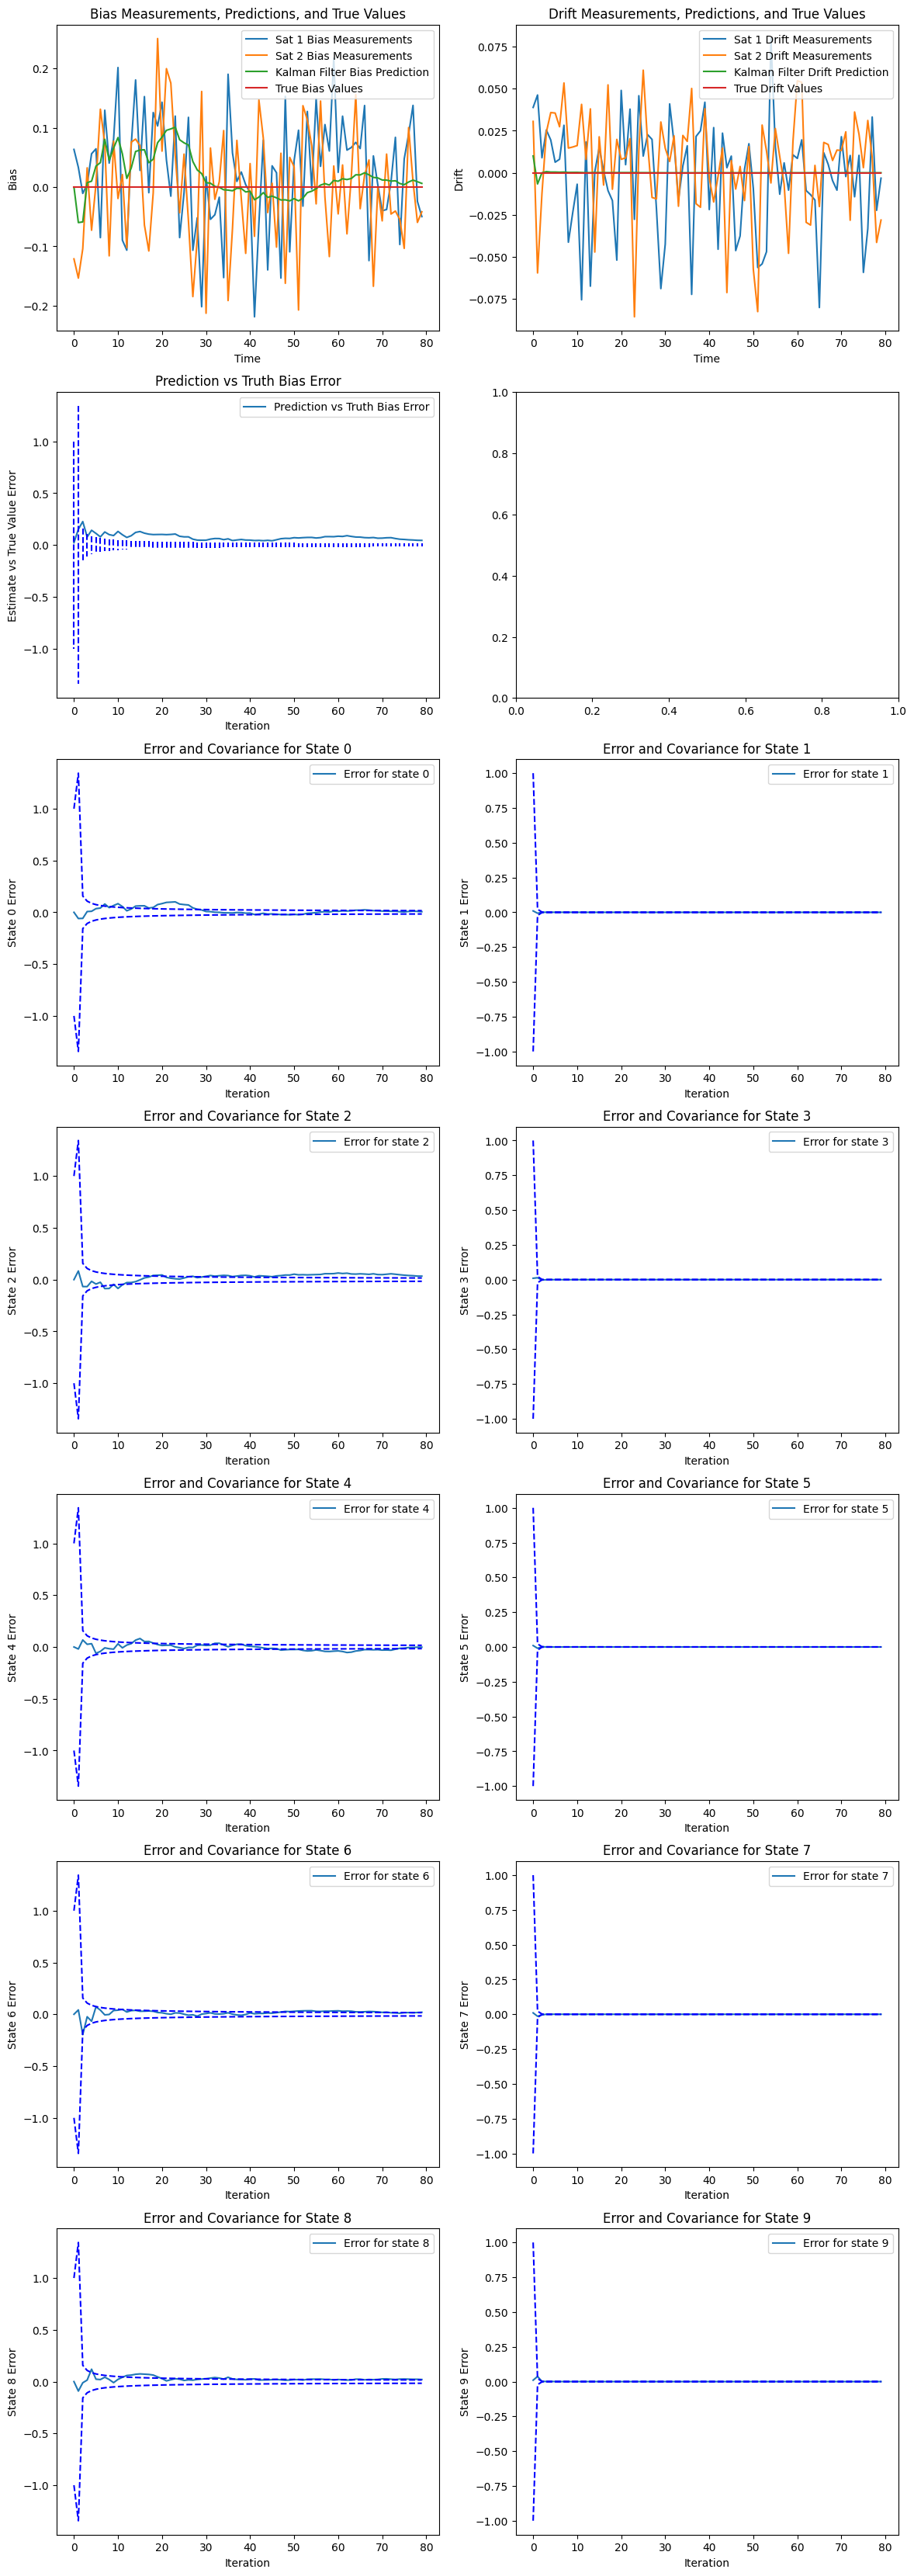

In [8]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

%run -n ./DiffusionLunarKF.ipynb
%run -n ./CentralizedLunarKF.ipynb